<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/Marine/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.stats import norm, shapiro, kstest, genextreme, genpareto
from scipy.stats import gamma
import scipy.stats as st


file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Mounted at /content/drive


# **Precipitation section**

In [7]:
ds_djf = ds.sel(time=ds['time'].dt.month.isin([1, 2, 12]))
print(ds_djf)
ds_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [8]:
somme_quotidienne_pr_djf=ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
print(somme_quotidienne_pr_djf)
X= somme_quotidienne_pr_djf
print(len(X))

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539755e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685729e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [9]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00


In [10]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [11]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [12]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
ds.time.values[10:]

array(['1940-01-11T00:00:00.000000000', '1940-01-12T00:00:00.000000000',
       '1940-01-13T00:00:00.000000000', ...,
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


In [15]:
da = ds['pr'].isel(time=0)   # un jour = une carte
df = da.to_dataframe().reset_index()

In [16]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


In [17]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [18]:
print(ds['pr'].shape)

(12, 14, 30449)


In [19]:
da = ds['pr'].isel(time=0)
print(da.shape)
print(da.values.size)

(12, 14)
168


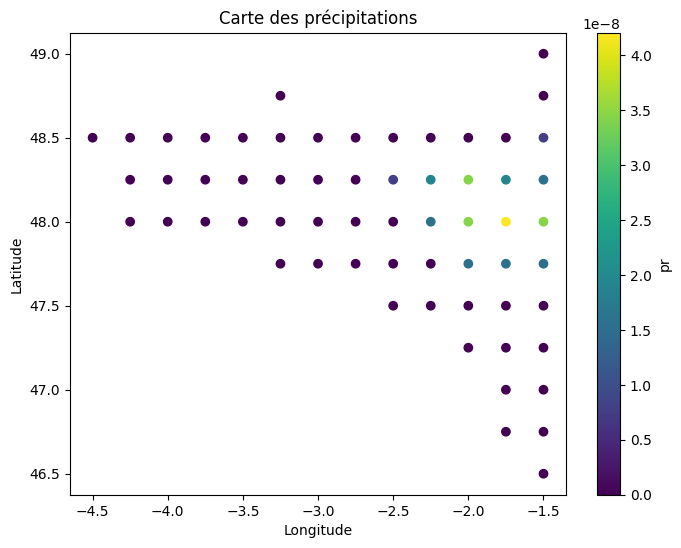

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

In [21]:
#conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X_mm_per_day = X_mm_per_day.rename("pr_mm_per_day")
X_mm_per_day.attrs['units'] = 'mm/day'
X_mm_per_day.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'


print(X_mm_per_day)

<xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794349e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


### **Wind section**

In [22]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [23]:
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [24]:
ds2_djf = ds2.sel(time=ds2['time'].dt.month.isin([1, 2, 12]))
print(ds2_djf)
ds2_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [25]:
mean_quotidienne_sfcWind_djf=ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)
Y= mean_quotidienne_sfcWind_djf
print(len(Y))

<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.834759 , 7.027803 , 6.503153 , ..., 8.036703 , 7.9032125,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


## **Etude des précipitations (X), distribution normale**

Paramètres normale : 0.0007912019 0.0026892326
Log-vraisemblance maximale : 33449.697388372704
AIC = -66895.39477674541


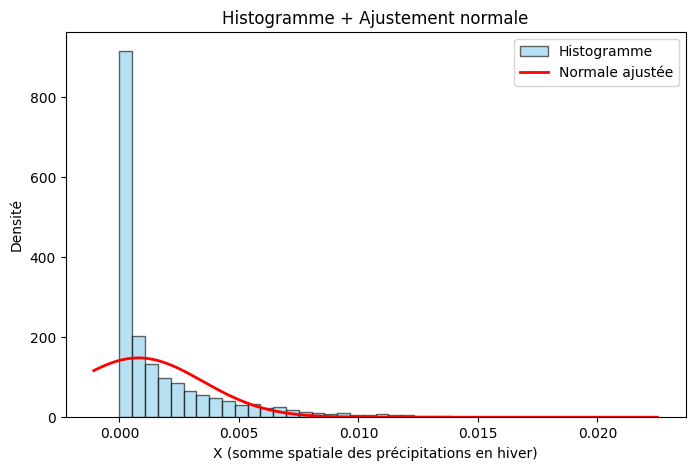

In [53]:

# Ajustement à la loi normale
mu, sigma = norm.fit(X)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(X, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)


In [57]:


# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(X)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(X, 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)



Test Shapiro-Wilk :
  statistique = 0.6938399511327104
  p-value     = 2.600751704575428e-79 

Test KS (paramètres estimés) :
  statistique = 0.38429631107701784
  p-value     = 0.0


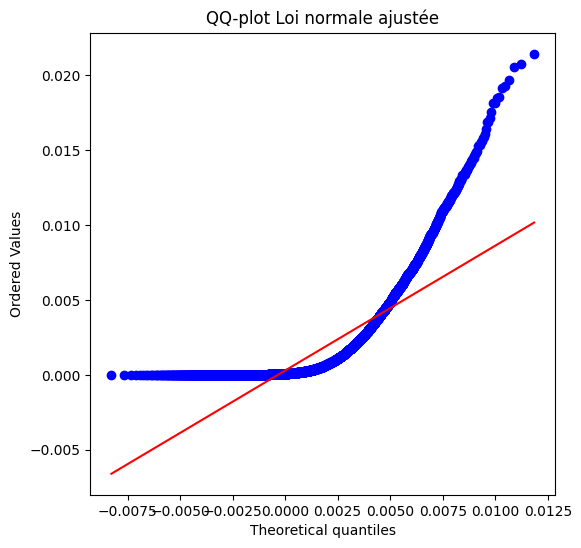

In [28]:
# Diagramme Quantile-Quantile de la normale
plt.figure(figsize=(6,6))
st.probplot(X, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

# **GEV précipitations:**

On définit un deux variables WinterPI qui correspond à la somme des précipitations d'un hiver (DJF) et Somme_mois qui correspond à la somme des précipitations par mois

In [29]:

# --- Conversion de pr de kg/m²/s en mm/jour ---
ds['pr'] = ds['pr'] * 86400  # 86400 secondes par jour
ds['season'] = ds['time'].dt.season

# Sélectionner seulement les jours d'hiver
ds_djf = ds.sel(time=ds['season'] == 'DJF')

# --- Somme quotidienne spatiale (Latitude + Longitude) ---
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])

# --- Somme mensuelle spatiale ---
somme_mois_pr_djf = ds_djf['pr'].groupby('time.month').sum(dim=['Latitude', 'Longitude'])

# --- Somme totale par hiver (chaque année) ---
# Note : On utilise groupby 'time.year'. Décembre appartient à l'année suivante pour l'hiver DJF
# Pour cela, on décale le mois de décembre d'une année
annee_hiver = ds_djf['time.year'].where(ds_djf['time.month'] != 12, ds_djf['time.year'] + 1)
somme_hiver = ds_djf['pr'].groupby(annee_hiver).sum(dim=['time', 'Latitude', 'Longitude'])

# --- Créer un DataArray WinterPI  et Somme par mois---
Somme_mois = somme_mois_pr_djf.rename("Somme mois")

WinterPI = somme_hiver.rename("WinterPI")
WinterPI = WinterPI.assign_coords(year=np.unique(annee_hiver.values))

# --- Afficher le résultat ---
print(WinterPI)
print(len(WinterPI))


<xarray.DataArray 'WinterPI' (year: 84)> Size: 336B
array([ 8377.799 , 15172.459 ,  7901.8545, 16133.89  ,  6146.8125,
       11490.911 , 13386.957 , 11288.445 , 13297.986 , 12569.238 ,
       13358.568 , 17136.406 ,  9778.834 ,  9171.723 ,  8722.051 ,
       15582.819 , 11727.835 , 17879.463 , 15123.016 , 11449.756 ,
       18136.957 , 16163.619 , 14360.942 ,  8398.139 ,  6663.288 ,
       12529.6875, 20239.215 , 14259.468 , 11374.627 , 12065.504 ,
       15991.568 ,  9821.185 , 15085.014 ,  9259.478 , 17334.346 ,
        9132.387 ,  5769.491 , 17019.125 , 19609.29  , 24382.764 ,
       16323.769 ,  9715.227 , 18556.426 , 13831.113 , 15407.055 ,
       14046.289 , 16734.344 ,  9234.358 , 20176.715 ,  7646.9746,
       24017.86  , 12432.268 ,  3969.125 , 11236.785 , 18439.773 ,
       24608.36  , 14611.942 , 10769.965 , 12307.036 , 14642.007 ,
       16343.527 , 23885.414 , 11435.121 , 16348.952 , 15704.693 ,
        6946.047 ,  9393.963 , 18730.018 , 13448.701 , 12046.453 ,
       161

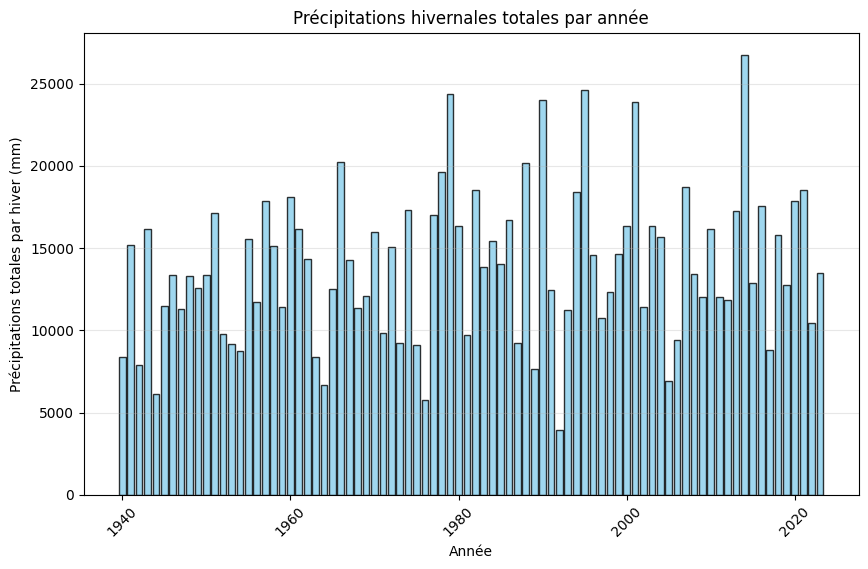

In [30]:
# Histogramme des précipitations par hiver pour chaque année
plt.figure(figsize=(10,6))
plt.bar(WinterPI.year, WinterPI.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Année")
plt.ylabel("Précipitations totales par hiver (mm)")
plt.title("Précipitations hivernales totales par année")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# GEV sur WinterPI

On étudie d'abord la gev sur WPI

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3562077006.py:16: SyntaxWarning: invalid escape sequence '\m'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')
/tmp/ipython-input-3562077006.py:16: SyntaxWarning: invalid escape sequence '\s'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')


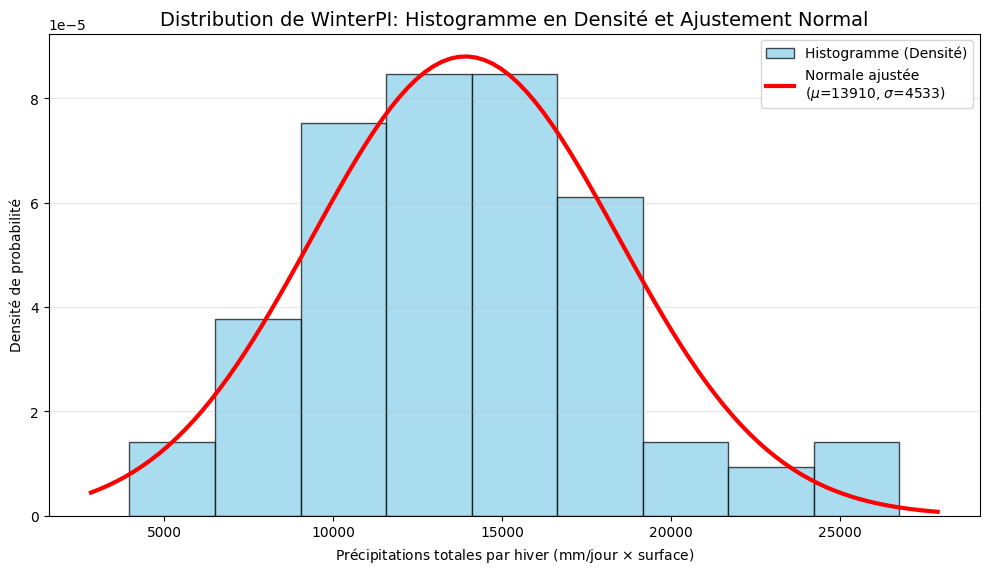

In [64]:
# --- Tracé de l'histogramme en densité ---
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(WinterPI.values)))

plt.hist(WinterPI.values, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# --- Courbe normale ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
# Utilisez les vraies valeurs mu et sigma obtenues
mu, sigma = norm.fit(WinterPI.values)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par hiver (mm/jour $\\times$ surface)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Paramètres GEV ajustés :
 c (shape) = -7.396, loc = 3969.84, scale = 5.32


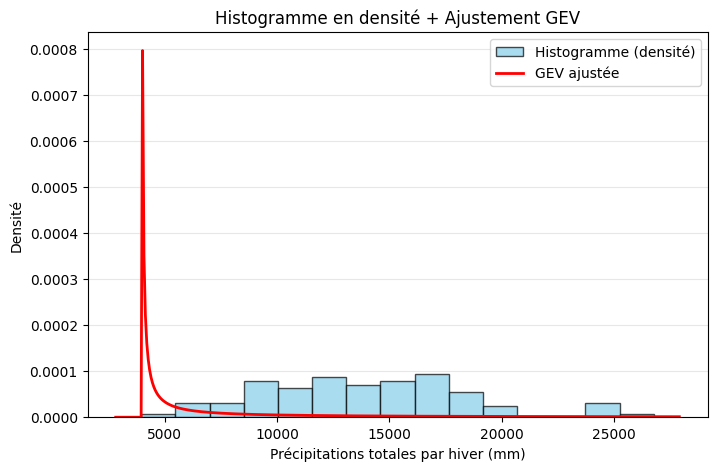

In [66]:

# --- Ajustement GEV ---
# genextreme utilise un paramètre c (shape), loc (location), scale (scale)
c, loc, scale = genextreme.fit(WinterPI.values)
print(f"Paramètres GEV ajustés :\n c (shape) = {c:.3f}, loc = {loc:.2f}, scale = {scale:.2f}")

# --- Histogramme en densité ---
plt.figure(figsize=(8,5))
plt.hist(WinterPI.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# --- Courbe GEV ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GEV ajustée')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par hiver (mm)")
plt.ylabel("Densité")
plt.title("Histogramme en densité + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



In [40]:

# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(WinterPI.values, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genextreme.logpdf(WinterPI.values, c, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)



Test KS (GEV ajustée) :
  Statistique = 0.8570189460574608
  p-value     = 3.1248954502754623e-71
Log-vraisemblance maximale : -1048.8730154700088
AIC = 2103.7460309400176


**Raisons du Mauvais Ajustement**

La cause principale de l'échec est due à la dégénérescence numérique causée par l'inadéquation de la GEV pour les données.

**GEV Inappropriée pour les Sommes :** La variable WinterPI est une somme accumulée (non des maximums). La GEV est théoriquement réservée à la série des maximums annuels (AMS).

**Instabilité Numérique :** L'ajustement échoue et la valeur de σ=5.3 est la preuve de la dégénérescence. L'algorithme a convergé vers une solution où la GEV est presque une fonction Dirac, d'où la courbe rouge très étroite et haute qui n'a pas de sens physique par rapport à la dispersion de l'histogramme.

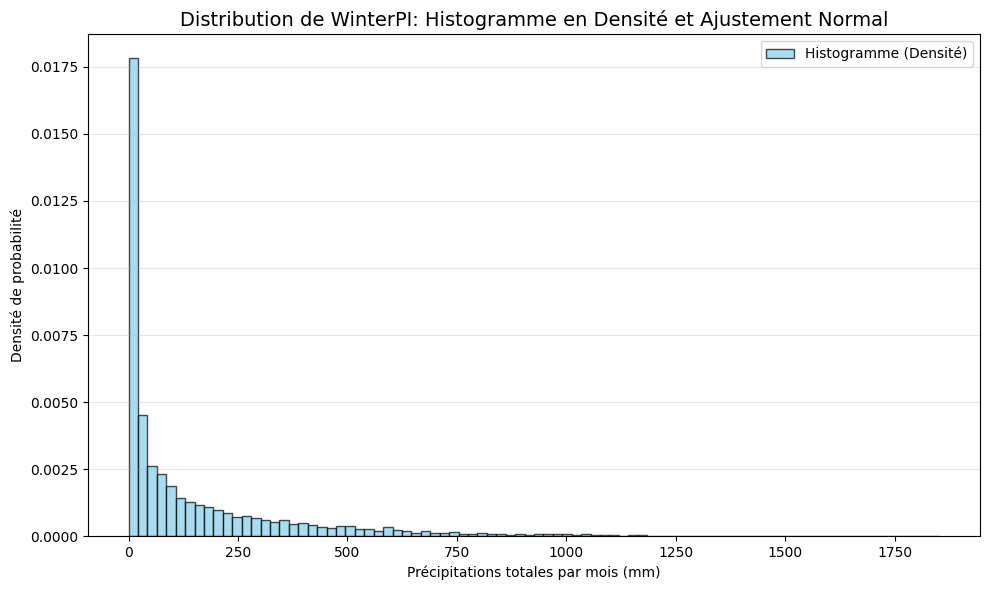

In [36]:
# --- Tracé de l'histogramme en densité ---
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(Somme_mois)))

plt.hist(Somme_mois, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par mois (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# **GPD précipitations**


# GPD sur WinterPI

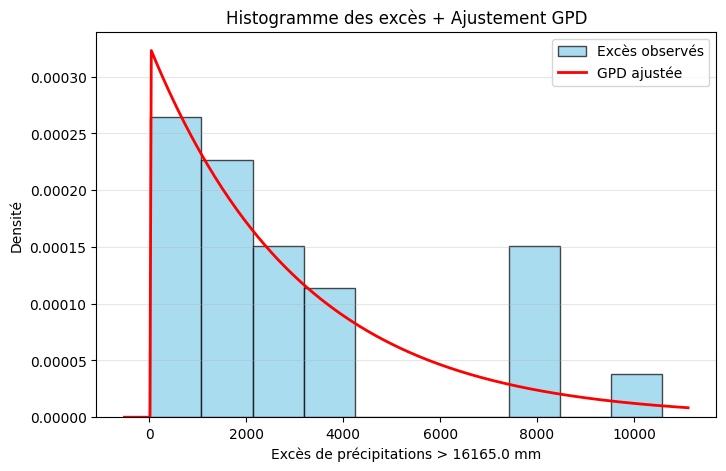

Paramètres GPD : shape(c)=-0.015, loc=12.4, scale=3070.9


In [61]:

# --- 1. Choisir un seuil pour les extrêmes ---
seuil = np.percentile(WinterPI.values, 70)  # 70ème percentile
exceedances = WinterPI.values[WinterPI.values > seuil] - seuil  # excès au-dessus du seuil

# --- 2. Ajuster la GPD aux excès ---
c, loc, scale = genpareto.fit(exceedances)

# --- 3. Histogramme des excès (densité) ---
plt.figure(figsize=(8,5))
plt.hist(exceedances, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# --- 4. Courbe GPD ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GPD ajustée')

# --- 5. Labels et légende ---
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 6. Affichage des paramètres ---
print(f"Paramètres GPD : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")


In [62]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(WinterPI.values, c, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.12264401154475968
  p-value     = 0.8030411135576355
Log-vraisemblance maximale : -1063.992458691212
AIC = 2133.984917382424


In [44]:
# Bloc maxima par saison
Somme_mois = Somme_mois.assign_coords(year=Somme_mois['time.year'].where(Somme_mois['time.month'] != 12, Somme_mois['time.year'] + 1))
data_max = Somme_mois.groupby('year').max(dim='month')
print(data_max)



AttributeError: 'DatetimeAccessor' object has no attribute 'to_period('M')'

In [ ]:
# Extraire les valeurs numériques
data_max_values = data_max.values

# Ajustement GEV
c, loc, scale = genextreme.fit(data_max_values)

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(data_max_values)))
plt.hist(data_max_values, bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")




In [38]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(data_max, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

NameError: name 'data_max' is not defined

Etude des vents, distribution normale

Paramètres normale : 5.404704 2.435008
Log-vraisemblance maximale : -18068.78117824422
AIC = 36141.56235648844
Test Shapiro-Wilk :
  statistique = 0.9672969474116843
  p-value     = 2.9708823471227656e-38 

Test KS :
  statistique = 0.11700889812487508
  p-value     = 1.6235751352349387e-90


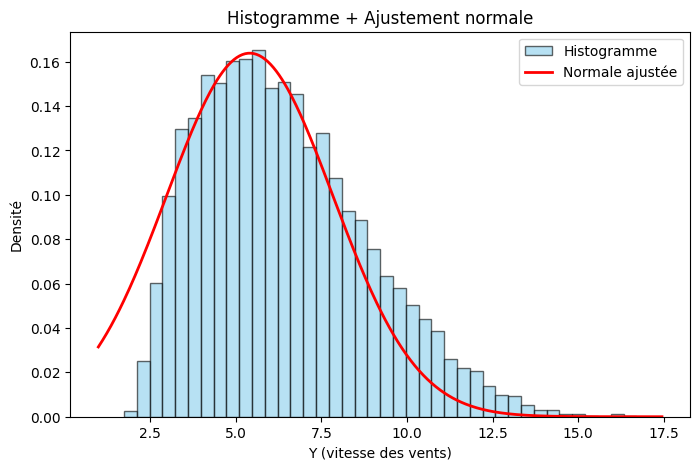

In [51]:
# Pour Y
# Ajustement à la loi normale
mu, sigma = norm.fit(Y-1)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(Y, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y, 'norm', args=(mu, sigma))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


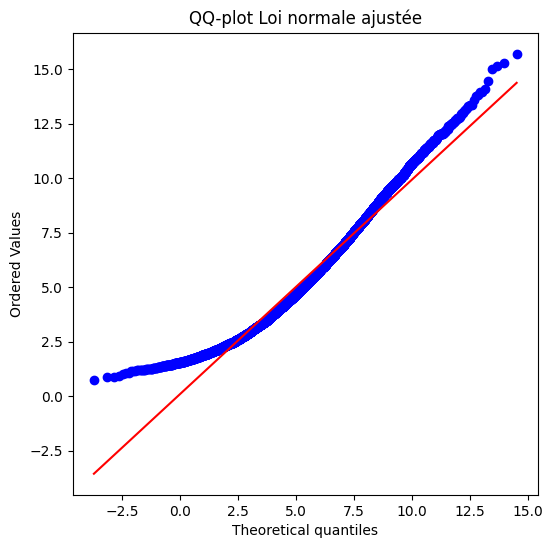

In [52]:
# Diagramme Quantile-Quantile de la noramle
plt.figure(figsize=(6,6))
st.probplot(Y, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()